In [ ]:
import kagglehub
vinayak123tyagi_bearing_dataset_path = kagglehub.dataset_download('vinayak123tyagi/bearing-dataset')

print('Data source import complete.')

100%|██████████| 1.56G/1.56G [01:07<00:00, 24.6MB/s]

Extracting files...


Data source import complete.


In [ ]:
print(vinayak123tyagi_bearing_dataset_path)

/root/.cache/kagglehub/datasets/vinayak123tyagi/bearing-dataset/versions/1


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow

from numpy.random import seed
from keras.layers import Input, Dropout

from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import os
import pandas as pd
import numpy as np

data_dir = '/root/.cache/kagglehub/datasets/vinayak123tyagi/bearing-dataset/versions/1/2nd_test/2nd_test'
data_frames = []
for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1, 4))
    dataset_mean_abs.index = [filename]
    data_frames.append(dataset_mean_abs)

merged_data = pd.concat(data_frames)

merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']


In [ ]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')

merged_data = merged_data.sort_index()
merged_data.to_csv('merged_Dataset_BearingTest_2.csv')
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [ ]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')

merged_data = merged_data.sort_index()
merged_data.to_csv('merged_Dataset_BearingTest_2.csv')
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


<Axes: >

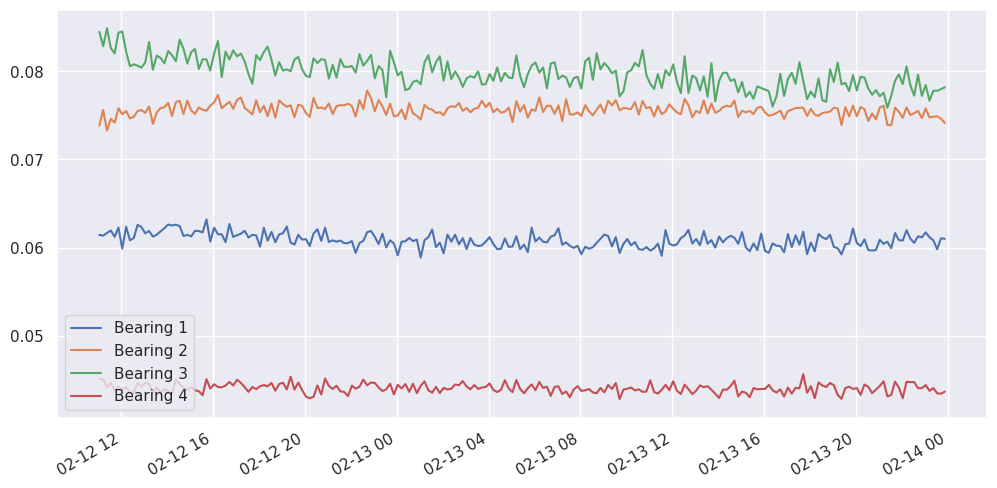

In [ ]:
# define train/test data
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]

dataset_train.plot(figsize = (12, 6))

In [ ]:
# Normalize data

scaler = preprocessing.MinMaxScaler()   # re-scale the data to be in the range [0, 1]

X_train = pd.DataFrame(scaler.fit_transform(dataset_train),
                       columns=dataset_train.columns,
                       index=dataset_train.index)

# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.fit_transform(dataset_test),
                       columns=dataset_test.columns,
                       index=dataset_test.index)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

X_train_PCA


,0,1
2004-02-12 11:02:39,0.401599,-0.106995
2004-02-12 11:12:39,0.429303,0.072144
2004-02-12 11:22:39,0.262169,-0.409915
2004-02-12 11:32:39,0.342785,-0.092068
2004-02-12 11:42:39,0.039415,-0.267742
...,...,...
2004-02-13 23:12:39,-0.263120,0.093145
2004-02-13 23:22:39,-0.182982,0.117398
2004-02-13 23:32:39,-0.418115,-0.014093
2004-02-13 23:42:39,-0.262979,-0.084781


In [ ]:
# Mahalanobis distance metric

def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")


def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

    return md

def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [ ]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [ ]:
covariance_matrix, inv_cov_matrix = cov_matrix(data_train)
mean_distr = data_train.mean(axis=0)

In [ ]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme=True)

In [ ]:
print("Calculated threshold:", threshold)

Calculated threshold: 3.8120454918056534


In [ ]:
print("Calculated threshold:", threshold)

Calculated threshold: 3.8120454918056534


(0.0, 15.0)

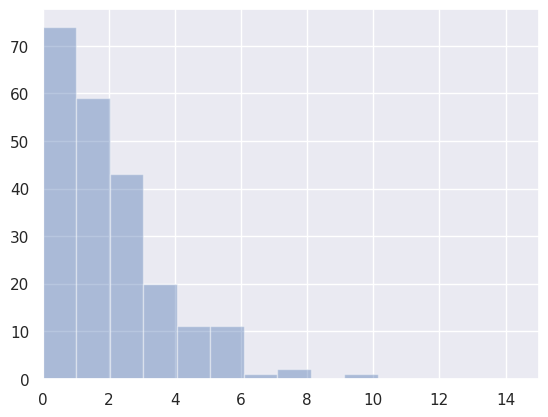

In [ ]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10,
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

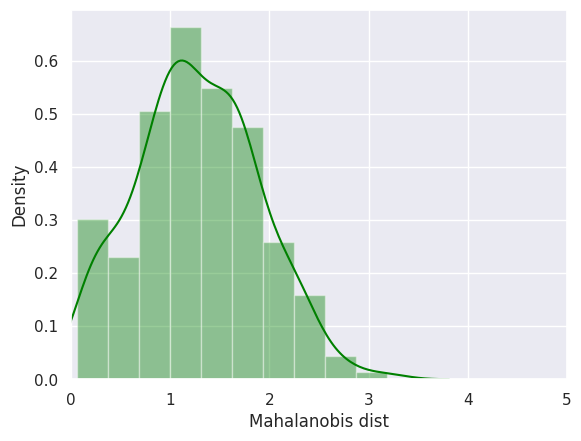

In [ ]:
plt.figure()
sns.distplot(dist_train,
             bins = 10,
             kde= True,
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [ ]:
import math
threshold = math.floor(threshold)
threshold

3

In [ ]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist'] = dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index

# test
anomaly = pd.DataFrame()
anomaly['Mob dist'] = dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
2004-02-13 23:52:39,0.895470,3,False
2004-02-14 00:02:39,0.884575,3,False
2004-02-14 00:12:39,0.898058,3,False
2004-02-14 00:22:39,0.863729,3,False
2004-02-14 00:32:39,0.873659,3,False


In [ ]:
anomaly[anomaly['Mob dist'] > 3]

,Mob dist,Thresh,Anomaly
2004-02-19 04:22:39,3.072163,3,True
2004-02-19 05:02:39,3.321952,3,True
2004-02-19 05:12:39,3.011165,3,True
2004-02-19 05:22:39,3.122537,3,True
2004-02-19 05:42:39,3.994028,3,True
2004-02-19 06:02:39,3.214215,3,True
2004-02-19 06:12:39,3.409025,3,True
2004-02-19 06:22:39,3.470308,3,True


In [ ]:
# merge the data in a single dataframe
anomaly_alldata = pd.concat([anomaly_train, anomaly])
# save as a .csv file
anomaly_alldata.to_csv('Anomaly_distance.csv')

<Axes: >

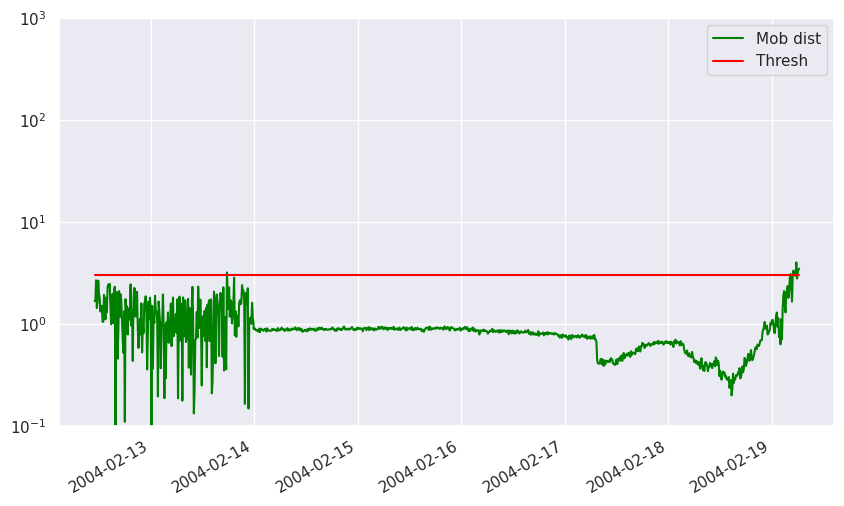

In [ ]:
# plot the calculated anomaly metric(Mob dist)
# check when it crosses the anomaly theshold

anomaly_alldata.plot(logy=True,    # logarithmic y-axis
                    figsize=(10, 6),
                    ylim = [1e-1, 1e3],
                    color = ['green', 'red'])


In [ ]:
import random
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

random.seed(10)
act_func = 'elu'

# Input layer:
model = Sequential()

# First hidden layer, connected to input vector X.
model.add(Dense(10, activation=act_func,
               kernel_initializer='glorot_uniform',
               kernel_regularizer=regularizers.l2(0.0),
               input_shape=(X_train.shape[1],)
           )
     )

model.add(Dense(2, activation=act_func,
               kernel_initializer='glorot_uniform'))

model.add(Dense(10, activation=act_func,
               kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1], kernel_initializer='glorot_uniform'))

model.compile(loss='mse', optimizer='adam')

from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')




# Train model for 100 epochs, batch size of 10:
NUM_EPOCHS = 100
BATCH_SIZE = 10


In [ ]:
history = model.fit(np.array(X_train), np.array(X_train),
                       batch_size=BATCH_SIZE,
                       epochs=NUM_EPOCHS,
                       validation_split=0.05,
                       verbose=1)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1658 - val_loss: 0.0423
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0568 - val_loss: 0.0187
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0266 - val_loss: 0.0226
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0215 - val_loss: 0.0209
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0198 - val_loss: 0.0198
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0198 - val_loss: 0.0194
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183 - val_loss: 0.0192
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173 - val_loss: 0.0181
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0188 - val_loss: 0.0181
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178 - val_loss: 0.0173
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - val_loss: 0.0172
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

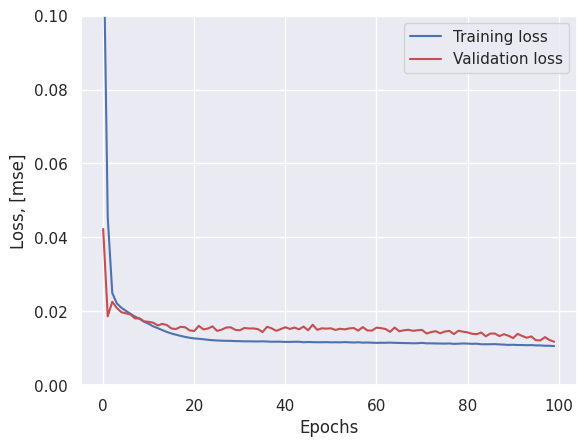

In [ ]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


(0.0, 0.5)

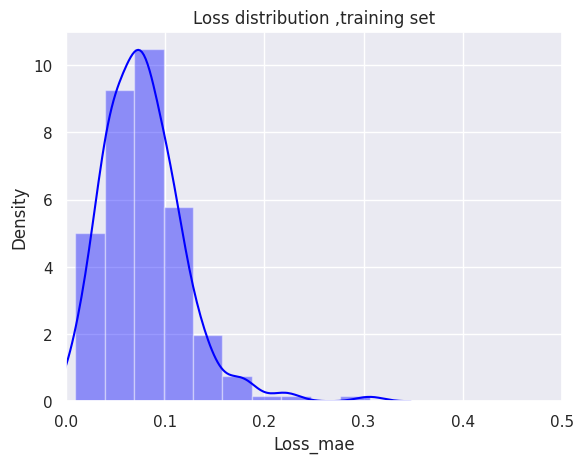

In [ ]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis=1)

plt.figure()
sns.distplot(scored['Loss_mae'],
            bins=10,
            kde=True,
            color='blue');
plt.title("Loss distribution ,training set")
plt.xlim([0.0, .5])  # set y-axis range

In [ ]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, MultiHeadAttention, LayerNormalization, Add, Reshape, Flatten
from tensorflow.keras import regularizers

random.seed(10)
act_func = 'elu'

# 🔹 Input layer
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))

# 🔹 Encoder with Self-Attention
x = Dense(10, activation=act_func, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0))(input_layer)

# 🔹 Reshape for MultiHeadAttention
x = Reshape((1, 10))(x)  # Reshape to (batch, sequence_length, features)

# 🔹 Multi-Head Attention Layer (Fixed)
attn_layer = MultiHeadAttention(num_heads=2, key_dim=10)(x, x)
attn_output = Add()([x, attn_layer])  # Skip connection
attn_output = LayerNormalization()(attn_output)  # Normalize

# 🔹 Flatten back to normal shape
attn_output = Flatten()(attn_output)

# 🔹 Bottleneck (Latent Representation)
encoded = Dense(2, activation=act_func, kernel_initializer='glorot_uniform')(attn_output)

# 🔹 Decoder
z = Dense(10, activation=act_func, kernel_initializer='glorot_uniform')(encoded)
decoded = Dense(input_dim, kernel_initializer='glorot_uniform')(z)

# 🔹 Define Attention-Based Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)

# 🔹 Compile the Model
autoencoder.compile(loss='mse', optimizer='adam')

# 🔹 Train the Model
NUM_EPOCHS = 100
BATCH_SIZE = 10

history = autoencoder.fit(X_train, X_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split=0.05, verbose=1)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.3426 - val_loss: 0.1611
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1723 - val_loss: 0.0790
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1230 - val_loss: 0.0417
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0748 - val_loss: 0.0223
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0449 - val_loss: 0.0218
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0328 - val_loss: 0.0219
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0255 - val_loss: 0.0227
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0228 - val_loss: 0.0223
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0230 - val_loss: 0.0213
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0201 - val_loss: 0.0210
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0201 - val_loss: 0.0210
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [ ]:
autoencoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 10)             │             50 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 10)          │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 1, 10)          │            870 │ reshape[0][0],         │
│ (MultiHeadAttention)      │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 10)          │              0 │ reshape[0][0],         │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 1, 10)          │             20 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 10)             │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 2)              │             22 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 10)             │             30 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 4)              │             44 │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,110 (12.15 KB)

 Trainable params: 1,036 (4.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,074 (8.11 KB)

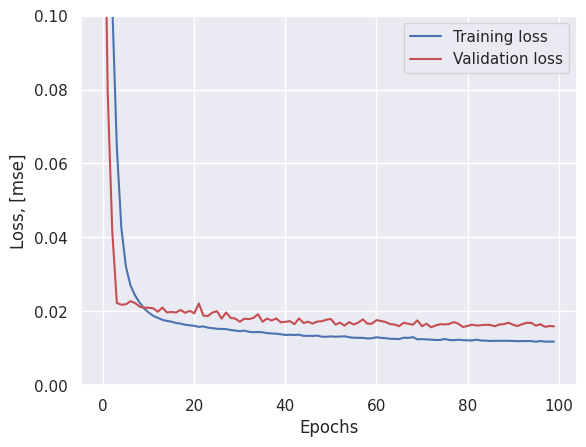

In [ ]:
# Plot training history
plt.plot(history.history['loss'], 'b', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


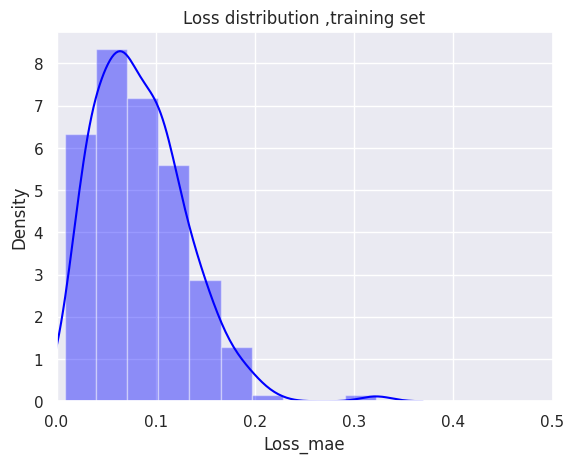

In [ ]:
# Predictions
X_pred = autoencoder.predict(X_train)
X_pred = pd.DataFrame(X_pred, columns=X_train.columns)
X_pred.index = X_train.index

# Compute loss
scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred - X_train), axis=1)

# Plot loss distribution
plt.figure()
sns.distplot(scored['Loss_mae'], bins=10, kde=True, color='blue')
plt.title("Loss distribution ,training set")
plt.xlim([0.0, .5])
plt.show()

In [ ]:
model.save('model.h5')
model.save('autoencoder.h5')

In [ ]:
!ls /content/

Anomaly_distance.csv  merged_Dataset_BearingTest_2.csv	model.png
autoencoder.h5	      model.h5				sample_data


In [ ]:
from tensorflow import keras
from keras.losses import mean_squared_error

loaded_model = keras.models.load_model('/content/model.h5', custom_objects={'mse': mean_squared_error})
loaded_model2 = keras.models.load_model('/content/autoencoder.h5', custom_objects={'mse': mean_squared_error})

In [ ]:
import tensorflow as tf

# Assuming 'loaded_model' is your loaded Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpbg9cjqa3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138830082194128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138830082193168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138830082192976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138830082191440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138830082191056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138830082188176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138830082191824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138830082187792: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
import tensorflow as tf

# Assuming 'loaded_model' is your loaded Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model2)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model2.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmp9hjzceli'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138830082190096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138830082189328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138830082188752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138830082189520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138830082188368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138830082187408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138830082189136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138830054119312: TensorSpec(shape=(), dtype=tf.resource, name=None)


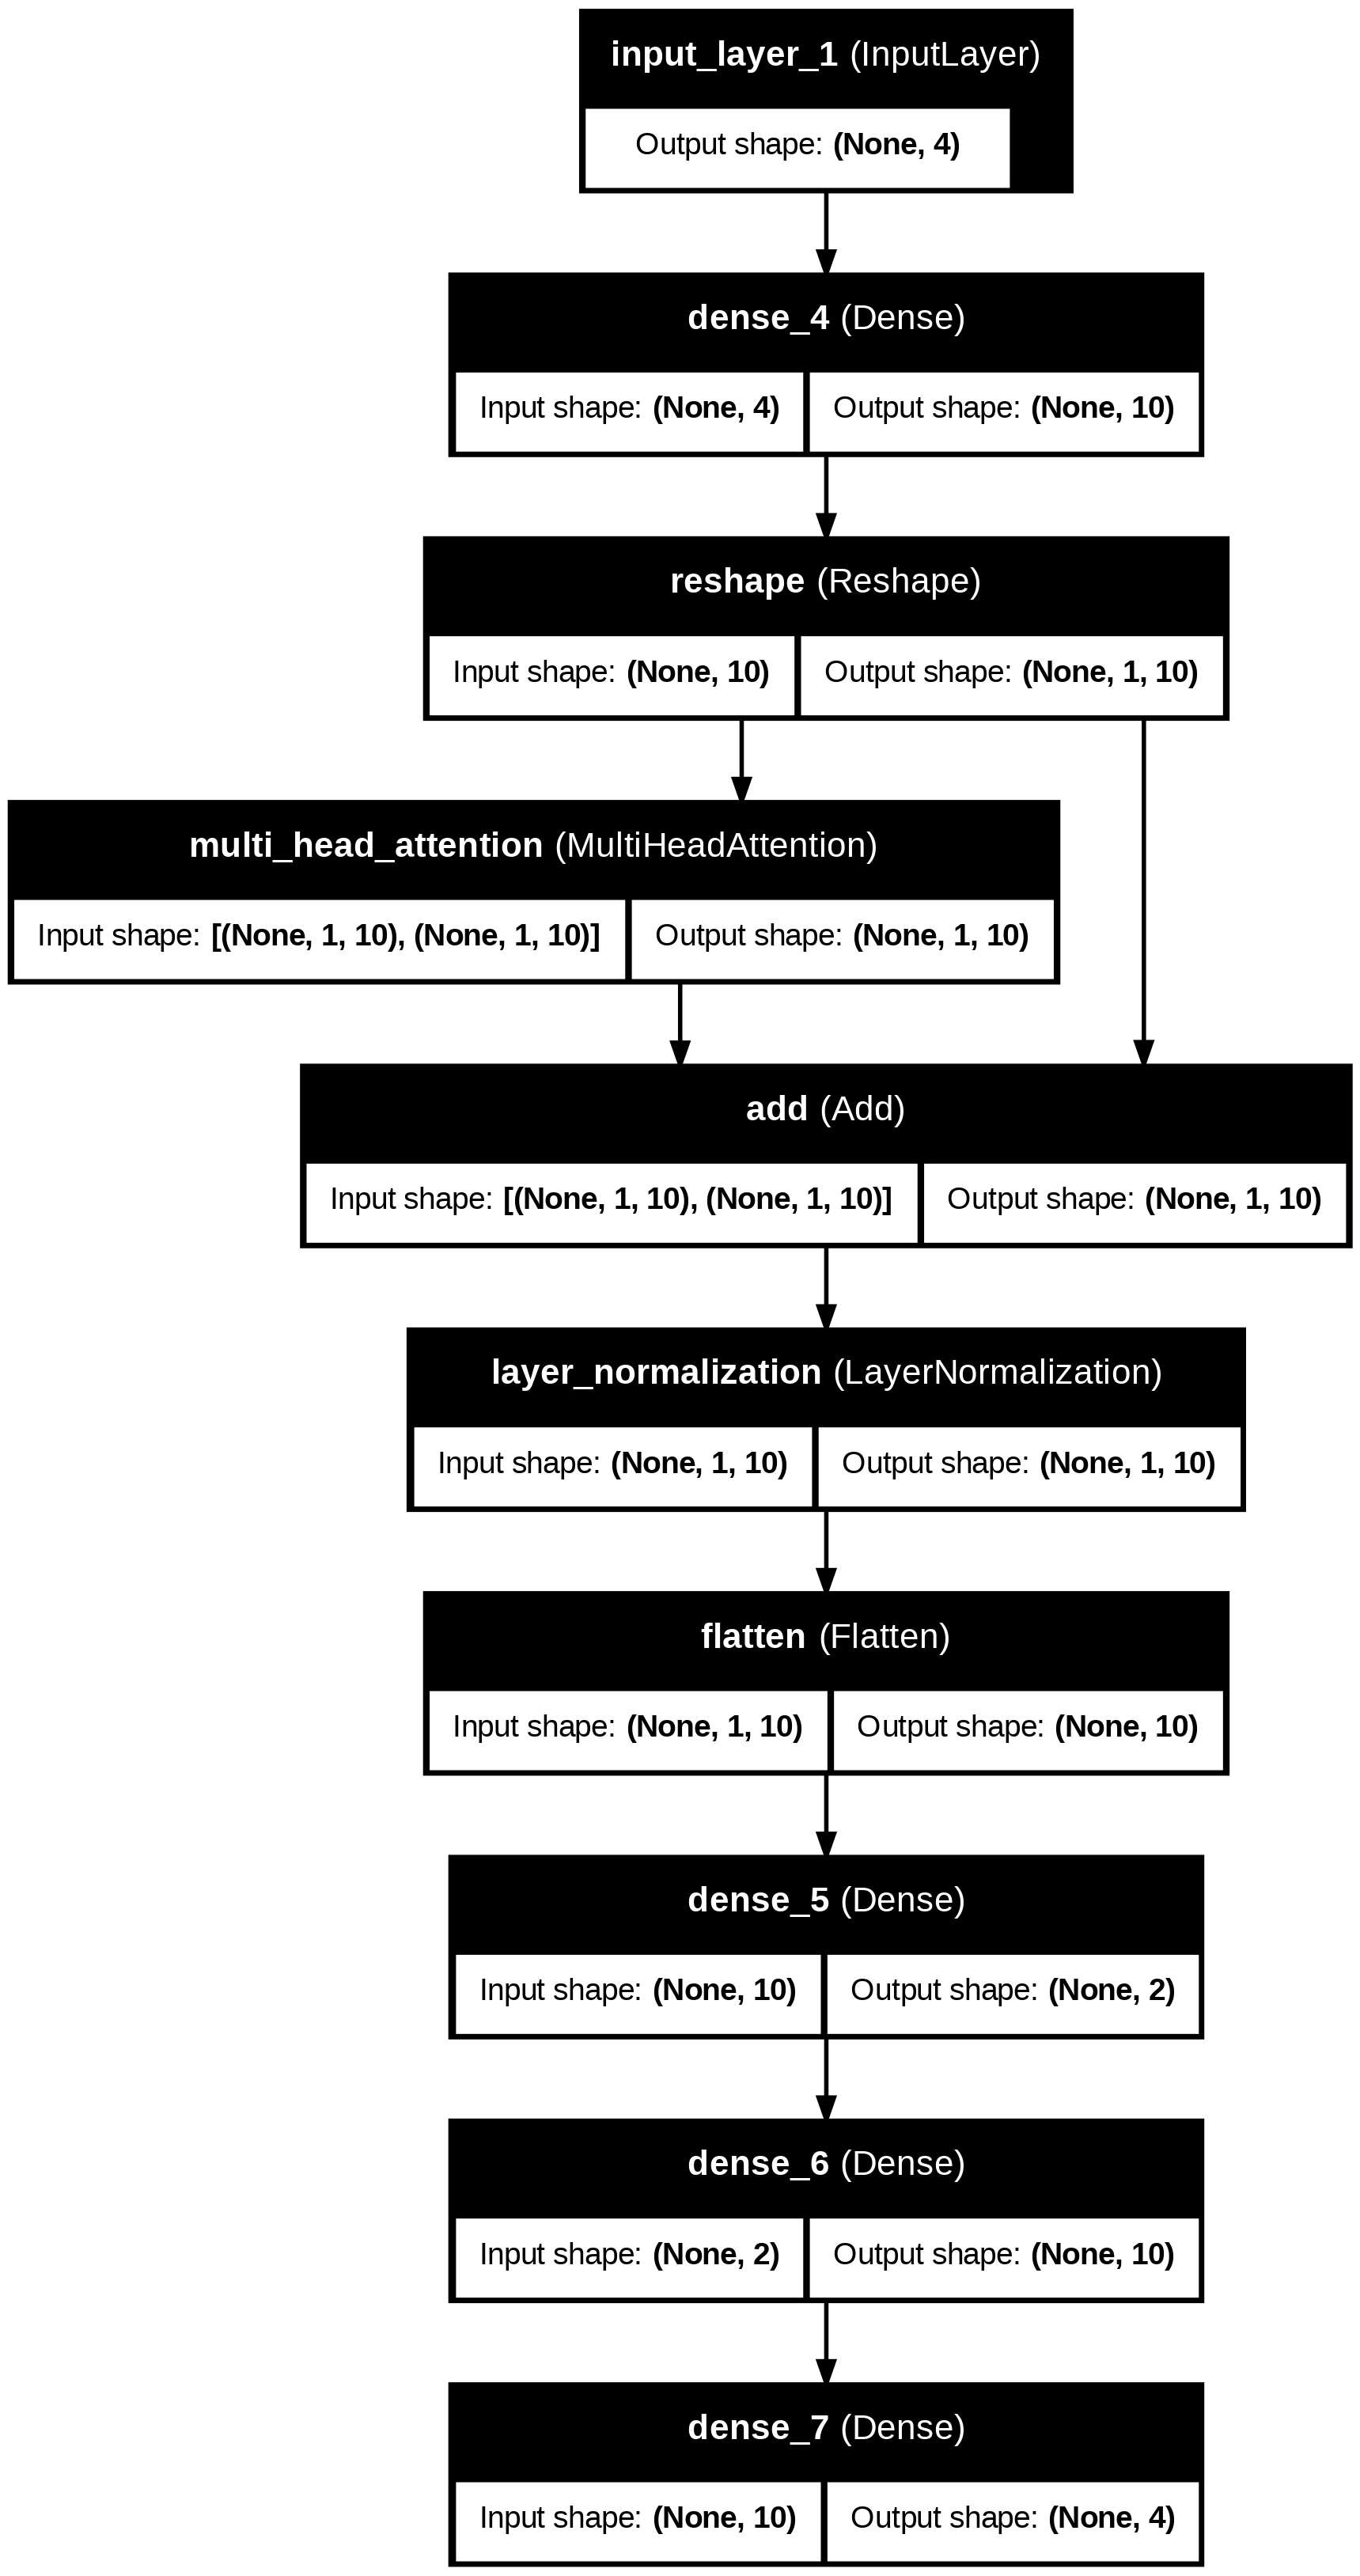

In [ ]:
plot_model(autoencoder, show_shapes=True, show_layer_names=True, to_file='autoencoder.png')

In [ ]:
!ls /content/

Anomaly_distance.csv  autoencoder.png			model2.tflite  model.png     sample_data
autoencoder.h5	      merged_Dataset_BearingTest_2.csv	model.h5       model.tflite


In [ ]:
from google.colab import files

files.download('model.tflite')
files.download('model2.tflite')
files.download('model.png')
files.download('autoencoder.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>